In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dataset = tfds.load("fashion_mnist" , split="train")
# dataset = tfds.load('fashion_mnist', split="train")

In [3]:
dataiterator = dataset.as_numpy_iterator()

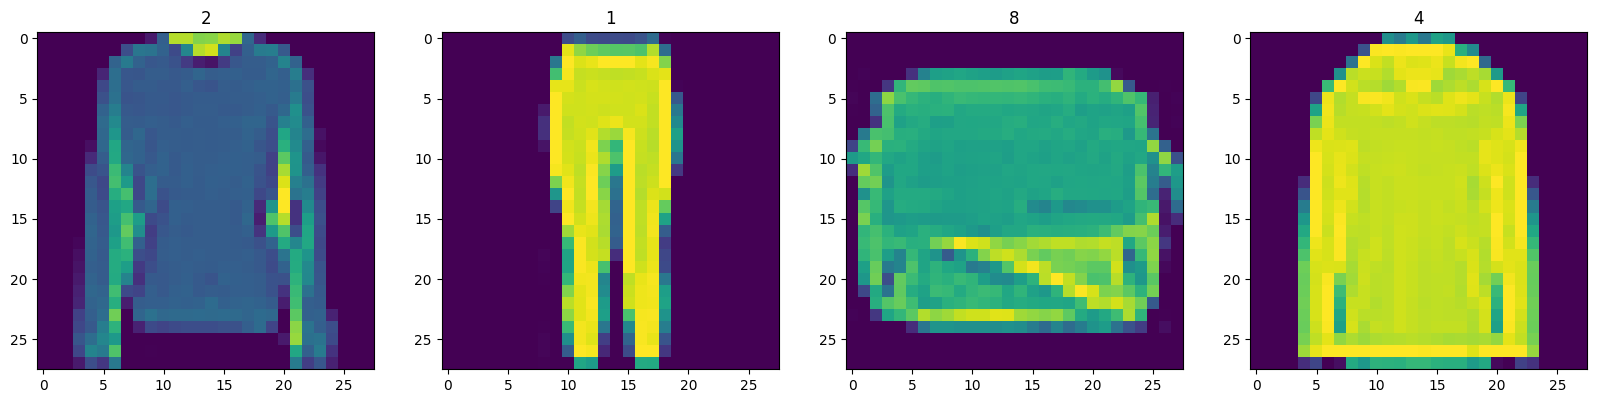

In [4]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for i in range(4):
  sample = dataiterator.next()
  ax[i].imshow(np.squeeze(sample['image']))
  ax[i].title.set_text(sample['label'])

In [5]:
def scale_image(data):
  image = data['image']
  return image/255


In [6]:
dataset = tfds.load("fashion_mnist" , split="train")

#  Map
dataset = dataset.map(scale_image)

# Cache
dataset = dataset.cache()

# shuffle
dataset = dataset.shuffle(60000)

#  batch
dataset = dataset.batch(128)

# prefetch
dataset = dataset.prefetch(64)

In [7]:
dataset.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [9]:
def build_generator():
  model = Sequential()

# Adding the dimension of input ie reshaping into  7 * 7 * 128 with input of 128
  model.add(Dense(7*7*128, input_dim = 128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

# Upsampling the dimension of input
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding="same"))
  model.add(LeakyReLU(0.2))

# upsampling the dimesnion 2
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding="same"))
  model.add(LeakyReLU(0.2))

# Down Sampling & Conv Block
  model.add(Conv2D(128,4,padding="same"))
  model.add(LeakyReLU(0.2))

# Down Sampling & Conv Block
  model.add(Conv2D(128,4,padding="same"))
  model.add(LeakyReLU(0.2))

# Final Conv Layer
  model.add(Conv2D(1,4,padding="same", activation = "sigmoid"))


  return model

In [10]:
generator = build_generator()

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [12]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 8s 8s/step


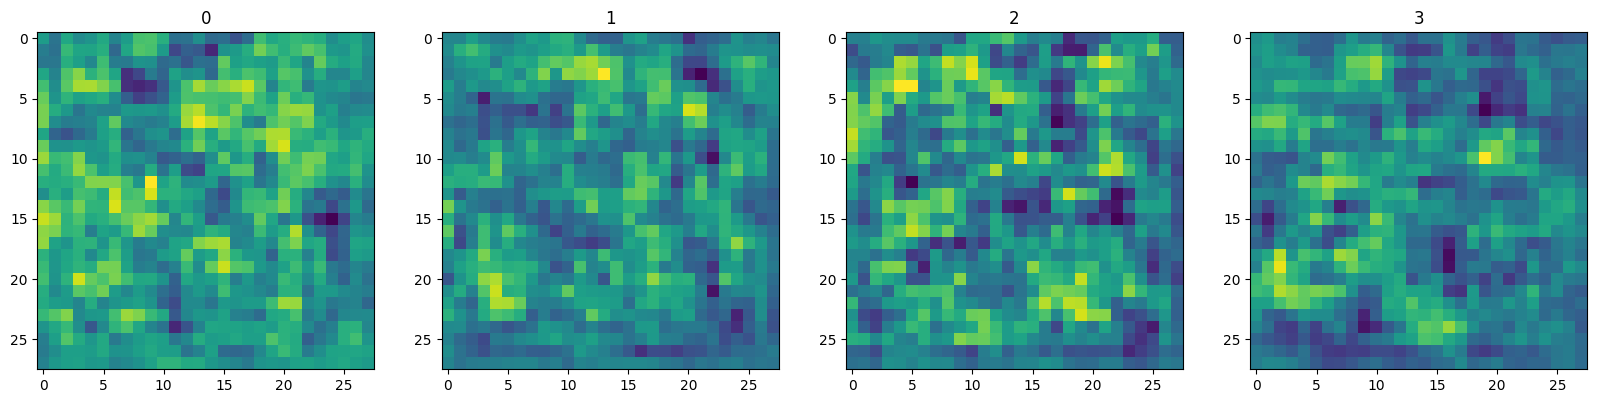

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in  enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)


In [14]:
def build_discriminator():
  model =  Sequential()

# First Conv Block
  model.add(Conv2D(32, 5, input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

# Second Conv Block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

# Third Conv Block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

# Second Conv Block
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

# Flatten Block
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation="sigmoid"))

  return model

In [15]:
discriminator = build_discriminator()

In [16]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [17]:
discriminator.predict(np.expand_dims(img,0))
# discriminator.predict(img)

1/1 [==============================] - 0s 376ms/step


array([[0.49651706]], dtype=float32)

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [19]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [20]:
# import the base model class to sub class our teaining step
from tensorflow.keras.models import Model

In [21]:
class FashionGAN(Model):
    def __init__(self,generator,discriminator, *args, **kwargs):
      super().__init__(*args,**kwargs)

      self.generator = generator
      self.discriminator = discriminator

    def compile(self,g_opt,d_opt,g_loss,d_loss,*args, **kwargs):
       super().compile(*args,**kwargs)

       self.g_opt = g_opt
       self.d_opt = d_opt
       self.g_loss = g_loss
       self.d_loss = d_loss


    def train_step(self,batch):
      real_images = batch
      fake_images = self.generator(tf.random.normal((128,128,1)),training=False)

     # Train the discriminator
      with tf.GradientTape() as d_tape:
          # pass out the real and fake images to the discriminator
          yhat_real = self.discriminator(real_images, training=True)
          yhat_fake = self.discriminator(fake_images, training=True)
          yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

          # Create labels for real and fake images
          y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)], axis=0)

          # Adding some noises to the True Outputs
          noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
          noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
          y_realfake = tf.concat([noise_real,noise_fake], axis=0)

          # Calculate the loss using BinaryCrossentropy
          total_d_loss = self.d_loss(y_realfake,yhat_realfake)

      # Apply Back Propogation - nn Learn
      dgrad = d_tape.gradient(total_d_loss,self.discriminator.trainable_variables)
      self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))

      with tf.GradientTape() as g_tape:
        # Generate some new images
        gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

        # Create the predicted labels
        predicted_labels = self.discriminator(gen_images,training=False)

        # Calculate loss -  trick to faking out the discriminator
        total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

      # Apply Back Propogation
      ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
      self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))

      return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [22]:
# Create instance of sub class model
fashgan = FashionGAN(generator,discriminator)

In [23]:
# Compile the model
fashgan.compile(g_opt,d_opt,g_loss,d_loss)

In [24]:
# Build Callback
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [35]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [38]:
# Recommend 2000 epochs
hist = fashgan.fit(dataset, epochs=100, callbacks=[ModelMonitor()])

  6/469 [..............................] - ETA: 2:17 - d_loss: 0.2689 - g_loss: 0.0777WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1353s vs `on_train_batch_end` time: 0.1612s). Check your callbacks.


469/469 [==============================] - 143s 305ms/step - d_loss: 0.2663 - g_loss: 0.0778


In [46]:
generator.load_weights(os.path.join('generator.h5'))

In [47]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 43ms/step


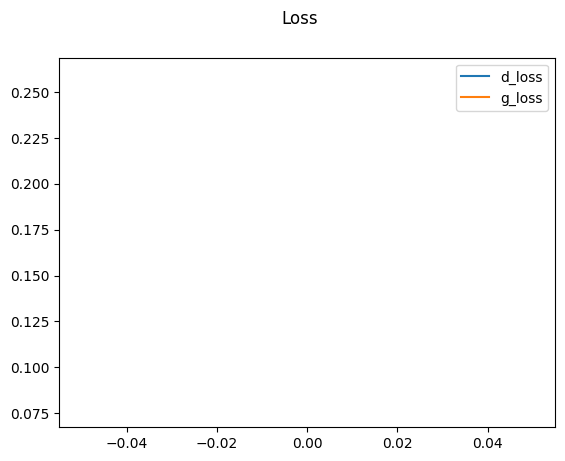

In [48]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [30]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')